In [ ]:
#@title run in case colab is stupid
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
#@title single-image testing
import torch
from torchvision.io import read_image
x = read_image('000001.jpg').float().unsqueeze(0)
x /= 255
img_size = (x.shape[-2], x.shape[-1])
device = 'cpu'
torch.save(x, 'x.pt')

In [ ]:
#@title clear memory

%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


#imports

You have to import vgg.pth, alex.pth, squeeze.pth first

In [ ]:
!mkdir weights
!mkdir weights/v0.1
!mv vgg.pth weights/v0.1/vgg.pth
!mv alex.pth weights/v0.1/alex.pth
!mv squeeze.pth weights/v0.1/squeeze.pth

In [ ]:
# https://github.com/milesial/Pytorch-UNet/tree/master/unet

# real shit

You have to import small.zip first

In [ ]:
#@title preprocessing
%%capture
!unzip small.zip
import os
from torchvision.io import read_image
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import Resize

!mkdir img_align_celeba_processed

img_size = None
resizer = None

batch_size = 25

def preprocess(batch_size: int) -> None:
    i = 0
    for _, _, filenames in os.walk('img_align_celeba'):
        imgs = []
        for filename in filenames:
            img = read_image(f'img_align_celeba/{filename}').float()
            img /= 255
            imgs.append(img)

            if len(imgs) == batch_size:
                batch = torch.stack(imgs)
                torch.save(batch, f'img_align_celeba_processed/{i}.pt')
                imgs.clear()
                i += 1

    global img_size, resizer
    img_size = (batch.shape[-2], batch.shape[-1])
    resizer = Resize(img_size)

preprocess(batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#@title full dataset (makes training a nightmare)

!pip install --upgrade --no-cache-dir gdown
from torchvision.datasets import CelebA
from torchvision import transforms

path = '/content'
target_type = 'attr'
download = True

preprocessing = transforms.Compose([transforms.ToTensor()])

training_set = CelebA(path + "/training/", download=download, split='train', target_type=target_type, transform=preprocessing)
# validation_set = CelebA(path + "/validation/", download=download, split='valid', target_type=target_type, transform=preprocessing)
# testing_set = CelebA(path + "/testing/", download=download, split='test', target_type=target_type, transform=preprocessing)

In [ ]:
#@title model (from multires_aes)
import torch.nn as nn
class AutoencoderBlock(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Maintains 218x178
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 109x89
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Maintains 109x89
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 54x44
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Maintains 54x44
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 27x22
            nn.Flatten(),
            nn.Linear(64 * 27 * 22, latent_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 27 * 22),
            nn.ReLU(),
            nn.Unflatten(1, (64, 27, 22)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 54x44
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 109x89
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=0),  # Outputs 218x178
            nn.Sigmoid()  # Ensures output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, high_latent_dim, low_latent_dim):
        super().__init__()
        self.high_res_autoencoder = AutoencoderBlock(high_latent_dim)
        self.low_res_autoencoder = AutoencoderBlock(low_latent_dim)

    def forward(self, image, mask):
        threshold = torch.mean(mask, dim=(1, 2, 3), keepdims=True) / 5
        fg_mask = mask >= threshold
        bg_mask = mask < threshold
        fg_mask_extra = mask >= threshold / 2
        bg_mask_extra = mask < threshold * 2

        fg_output = self.high_res_autoencoder(image * fg_mask_extra)
        bg_output = self.low_res_autoencoder(image * bg_mask_extra)

        return fg_output, fg_mask, bg_output, bg_mask

In [ ]:
#@title stupid model (didn't work)

import torch
import torch.nn as nn
from torchvision.transforms import Resize

class DenseBlock(nn.Module):
    def __init__(self, h_in: int, w_in: int, h_out: int, w_out: int) -> None:
        super().__init__()
        layer_size = h_in * w_in

        self.net = nn.Sequential(
            nn.Flatten(2),
            nn.LazyLinear(layer_size),
            nn.GELU(),
            nn.LazyLinear(layer_size),
            nn.GELU(),
            nn.LazyLinear(h_out * w_out),
            nn.Tanhshrink(),
            nn.Unflatten(2, torch.Size([h_out, w_out]))
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # print('dense block before: ', x.shape)
        x = self.net(x)
        # print('dense block after: ', x.shape)
        return x


class EncoderResnetBlock(nn.Module):
    def __init__(self, num_channels: int) -> None:
        super().__init__()
        self.kernel_size = 3
        self.channels = num_channels

        self.conv = nn.Sequential(
            nn.LazyConv2d(self.channels, kernel_size=self.kernel_size, padding='same'),
            nn.GELU(),
            nn.LazyConv2d(self.channels, kernel_size=self.kernel_size, padding='same'),
            nn.GELU(),
            nn.LazyConv2d(self.channels, kernel_size=self.kernel_size, padding='same'),
            nn.Tanhshrink()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # print('encoder resnet: ', x.shape)
        return x + self.conv(x)


class Conv(nn.Module):
    def __init__(self, transpose: bool, out_channels: int, kernel_size: int = 5, stride: int = 1, end: bool = False) -> None:
        super().__init__()

        if transpose:
            self.conv = nn.LazyConvTranspose2d(out_channels, kernel_size=kernel_size, stride=stride)
        else:
            self.conv = nn.LazyConv2d(out_channels, kernel_size=kernel_size, stride=stride)

        self.activation = nn.Tanhshrink() if end else nn.GELU()
        self.net = nn.Sequential(
            nn.LazyBatchNorm2d(),
            self.conv,
            self.activation
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.net(x)
        # print('conv: ', x.shape)
        return x


class DecoderResnetBlock(nn.Module):
    def __init__(self, num_channels: int) -> None:
        super().__init__()
        kernel_size = 3
        padding = (kernel_size - 1) // 2

        self.conv = nn.Sequential(
            nn.LazyConvTranspose2d(num_channels, kernel_size=kernel_size, padding=padding),
            nn.GELU(),
            nn.LazyConvTranspose2d(num_channels, kernel_size=kernel_size, padding=padding),
            nn.GELU(),
            nn.LazyConvTranspose2d(num_channels, kernel_size=kernel_size, padding=padding),
            nn.Tanhshrink()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # print('decoder resnet: ', x.shape)
        return x + self.conv(x)


class Autoencoder(nn.Module):
    def __init__(self, image_size: tuple[int, int, int]) -> None:
        super().__init__()
        self.channels, self.height, self.width = image_size
        self.hidden_channels = 64
        self.latent_size = 1000

        self.encoder = nn.Sequential(
            EncoderResnetBlock(self.channels),
            Conv(transpose=False, out_channels=self.hidden_channels // 4, kernel_size=10),

            EncoderResnetBlock(self.hidden_channels // 4),
            Conv(transpose=False, out_channels=self.hidden_channels // 3, stride=2),

            EncoderResnetBlock(self.hidden_channels // 3),
            Conv(transpose=False, out_channels=self.hidden_channels // 2),

            EncoderResnetBlock(self.hidden_channels // 2),
            Conv(transpose=False, out_channels=self.hidden_channels, stride=2),

            EncoderResnetBlock(self.hidden_channels),
            Conv(transpose=False, out_channels=self.hidden_channels),

            EncoderResnetBlock(self.hidden_channels),
            Conv(transpose=False, out_channels=self.hidden_channels // 2, stride=2),
            DenseBlock(20, 15, 20, 15),

            EncoderResnetBlock(self.hidden_channels // 2),
            Conv(transpose=False, out_channels=self.hidden_channels // 3),
            DenseBlock(16, 11, 16, 11),
            DenseBlock(16, 11, 16, 11),

            nn.Flatten(),
            nn.LazyLinear(self.latent_size),
            nn.Tanhshrink()
        )
        self.decoder = nn.Sequential(
            nn.LazyLinear(self.hidden_channels // 3 * 16 * 11),
            nn.GELU(),

            nn.Unflatten(1, torch.Size([self.hidden_channels // 3, 16, 11])),

            DenseBlock(16, 11, 16, 11),
            DenseBlock(16, 11, 16, 11),
            Conv(transpose=True, out_channels=self.hidden_channels // 2),
            DecoderResnetBlock(self.hidden_channels // 2),

            DenseBlock(20, 15, 20, 15),
            Conv(transpose=True, out_channels=self.hidden_channels, stride=2),
            Resize((44, 34)),
            DecoderResnetBlock(self.hidden_channels),

            Conv(transpose=True, out_channels=self.hidden_channels),
            DecoderResnetBlock(self.hidden_channels),

            Conv(transpose=True, out_channels=self.hidden_channels // 2, stride=2),
            DecoderResnetBlock(self.hidden_channels // 2),

            Conv(transpose=True, out_channels=self.hidden_channels // 3),
            DecoderResnetBlock(self.hidden_channels // 3),

            Conv(transpose=True, out_channels=self.hidden_channels // 4, stride=2),
            DecoderResnetBlock(self.hidden_channels // 4),

            Conv(transpose=True, out_channels=self.channels, end=True, kernel_size=10),
            DecoderResnetBlock(self.channels),

            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # print('input: ', x.shape)
        x = self.encoder(x)
        # print('encoded: ', x.shape)
        x = self.decoder(x)
        # print('decoded: ', x.shape)
        return x

In [ ]:
#@title model diagnostics
img_path = 'img_align_celeba_processed/0.pt' #@param {type: "string"}

def get_model_properties(img_path: str) -> None:
    imgs = torch.load(img_path).to(device)
    model = Autoencoder((3, imgs.shape[-2], imgs.shape[-1])).to(device)

    encoded = model.encoder(imgs)
    decoded = model.decoder(encoded)

    dims_original = imgs.shape
    dims_latent = encoded.shape
    size_original = torch.prod(torch.tensor(dims_original)).item()
    size_latent = torch.prod(torch.tensor(dims_latent)).item()

    del imgs, encoded, decoded

    total_params = 0
    for name, p in model.named_parameters():
        if p.requires_grad:
            print(f'{p.numel()}\t{name}')
            total_params += p.numel()

    print("----------------")
    print('TOTAL PARAMS: ', total_params)
    print("----------------")
    print("IMAGE SIZES:")
    print(f'original\t{list(dims_original)}')
    print(f'latent  \t{list(dims_latent)}')
    print("----------------")
    print('COMPRESSION FACTOR:')
    print(f"{size_latent} / {size_original} = {100 * size_latent / size_original}%")
    print("----------------")

    del model
    torch.cuda.empty_cache()

get_model_properties(img_path)

In [ ]:
#@title depth
from transformers import pipeline
from tqdm import tqdm

checkpoint = "vinvino02/glpn-nyu"
depth_estimator = pipeline("depth-estimation", model=checkpoint, device=0)

def preprocess_depths(path: str = 'img_align_celeba'):
    !mkdir depths
    for _, _, filenames in os.walk(path):
        filenames = [f'{path}/{x}' for x in filenames]
        j = 0
        for i in tqdm(range(0, len(filenames), batch_size)):
            image_depths = torch.stack([x['predicted_depth'][0] for x in depth_estimator(filenames[i:i + batch_size])])
            image_depths = image_depths * torch.abs(image_depths)
            image_depths = torch.exp(-image_depths)
            image_depths /= torch.sum(image_depths)
            image_depths /= torch.amax(image_depths, dim=(1, 2), keepdim=True)
            torch.save(image_depths, f'depths/{j}.pt')
            j += 1
        del image_depths
        torch.cuda.empty_cache()
preprocess_depths()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/245M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

  2%|▎         | 10/400 [00:15<09:59,  1.54s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 400/400 [09:10<00:00,  1.38s/it]


In [ ]:
#@title ms-ssim
# Copyright 2020 by Gongfan Fang, Zhejiang University.
# All rights reserved.

# %%capture
# !pip install pytorch-msssim
# from pytorch_msssim import ms_ssim, MS_SSIM

import warnings
from typing import List, Optional, Tuple, Union

import torch
import torch.nn.functional as F
from torch import Tensor


def _fspecial_gauss_1d(size: int, sigma: float) -> Tensor:
    r"""Create 1-D gauss kernel
    Args:
        size (int): the size of gauss kernel
        sigma (float): sigma of normal distribution
    Returns:
        torch.Tensor: 1D kernel (1 x 1 x size)
    """
    coords = torch.arange(size, dtype=torch.float)
    coords -= size // 2

    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g /= g.sum()

    return g.unsqueeze(0).unsqueeze(0)


def gaussian_filter(input: Tensor, win: Tensor) -> Tensor:
    r""" Blur input with 1-D kernel
    Args:
        input (torch.Tensor): a batch of tensors to be blurred
        window (torch.Tensor): 1-D gauss kernel
    Returns:
        torch.Tensor: blurred tensors
    """
    assert all([ws == 1 for ws in win.shape[1:-1]]), win.shape
    if len(input.shape) == 4:
        conv = F.conv2d
    elif len(input.shape) == 5:
        conv = F.conv3d
    else:
        raise NotImplementedError(input.shape)

    C = input.shape[1]
    out = input
    for i, s in enumerate(input.shape[2:]):
        if s >= win.shape[-1]:
            out = conv(out, weight=win.transpose(2 + i, -1), stride=1, padding=0, groups=C)
        else:
            warnings.warn(
                f"Skipping Gaussian Smoothing at dimension 2+{i} for input: {input.shape} and win size: {win.shape[-1]}"
            )

    return out


def _ssim(
    X: Tensor,
    Y: Tensor,
    data_range: float,
    win: Tensor,
    size_average: bool = True,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03),
    mask: Tensor = None
) -> Tuple[Tensor, Tensor]:
    r""" Calculate ssim index for X and Y

    Args:
        X (torch.Tensor): images
        Y (torch.Tensor): images
        data_range (float or int): value range of input images. (usually 1.0 or 255)
        win (torch.Tensor): 1-D gauss kernel
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: ssim results.
    """
    K1, K2 = K
    # batch, channel, [depth,] height, width = X.shape
    compensation = 1.0

    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    win = win.to(X.device, dtype=X.dtype)

    mu1 = gaussian_filter(X, win)
    mu2 = gaussian_filter(Y, win)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = compensation * (gaussian_filter(X * X, win) - mu1_sq)
    sigma2_sq = compensation * (gaussian_filter(Y * Y, win) - mu2_sq)
    sigma12 = compensation * (gaussian_filter(X * Y, win) - mu1_mu2)

    cs_map = (2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)  # set alpha=beta=gamma=1

    if mask is not None:
        resizing = Resize(cs_map.shape[-2:])
        weights = resizing(mask).to(device).float()
        cs_map = 2 * (((cs_map + 1) / 2) ** weights) - 1

    ssim_map = ((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs_map

    # plt.imshow(ssim_map[0].cpu().detach().numpy()[0])
    # plt.colorbar()
    # plt.show()

    # plt.imshow(ssim_map[0].cpu().detach().numpy()[0])
    # plt.colorbar()
    # plt.show()

    ssim_per_channel = torch.flatten(ssim_map, 2).mean(-1)
    cs = torch.flatten(cs_map, 2).mean(-1)
    return ssim_per_channel, cs


def ms_ssim(
    X: Tensor,
    Y: Tensor,
    data_range: float = 255,
    size_average: bool = True,
    win_size: int = 11,
    win_sigma: float = 1.5,
    win: Optional[Tensor] = None,
    weights: Optional[List[float]] = None,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03),
    mask: Tensor = None
) -> Tensor:
    r""" interface of ms-ssim
    Args:
        X (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        Y (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
        win_size: (int, optional): the size of gauss kernel
        win_sigma: (float, optional): sigma of normal distribution
        win (torch.Tensor, optional): 1-D gauss kernel. if None, a new kernel will be created according to win_size and win_sigma
        weights (list, optional): weights for different levels
        K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
    Returns:
        torch.Tensor: ms-ssim results
    """
    if not X.shape == Y.shape:
        raise ValueError(f"Input images should have the same dimensions, but got {X.shape} and {Y.shape}.")

    for d in range(len(X.shape) - 1, 1, -1):
        X = X.squeeze(dim=d)
        Y = Y.squeeze(dim=d)

    #if not X.type() == Y.type():
    #    raise ValueError(f"Input images should have the same dtype, but got {X.type()} and {Y.type()}.")

    if len(X.shape) == 4:
        avg_pool = F.avg_pool2d
    elif len(X.shape) == 5:
        avg_pool = F.avg_pool3d
    else:
        raise ValueError(f"Input images should be 4-d or 5-d tensors, but got {X.shape}")

    if win is not None:  # set win_size
        win_size = win.shape[-1]

    if not (win_size % 2 == 1):
        raise ValueError("Window size should be odd.")

    smaller_side = min(X.shape[-2:])
    assert smaller_side > (win_size - 1) * (
        2 ** 4
    ), "Image size should be larger than %d due to the 4 downsamplings in ms-ssim" % ((win_size - 1) * (2 ** 4))

    if weights is None:
        weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    weights_tensor = X.new_tensor(weights)

    if win is None:
        win = _fspecial_gauss_1d(win_size, win_sigma)
        win = win.repeat([X.shape[1]] + [1] * (len(X.shape) - 1))

    levels = weights_tensor.shape[0]
    mcs = []
    for i in range(levels):
        ssim_per_channel, cs = _ssim(X, Y, win=win, data_range=data_range, size_average=False, K=K, mask=mask)
        mask = None

        if i < levels - 1:
            mcs.append(torch.relu(cs))
            padding = [s % 2 for s in X.shape[2:]]
            X = avg_pool(X, kernel_size=2, padding=padding)
            Y = avg_pool(Y, kernel_size=2, padding=padding)

    ssim_per_channel = torch.relu(ssim_per_channel)  # type: ignore  # (batch, channel)
    mcs_and_ssim = torch.stack(mcs + [ssim_per_channel], dim=0)  # (level, batch, channel)
    ms_ssim_val = torch.prod(mcs_and_ssim ** weights_tensor.view(-1, 1, 1), dim=0)

    if size_average:
        return ms_ssim_val.mean()
    else:
        return ms_ssim_val.mean(1)

class MS_SSIM(torch.nn.Module):
    def __init__(
        self,
        data_range: float = 255,
        size_average: bool = True,
        win_size: int = 11,
        win_sigma: float = 1.5,
        channel: int = 3,
        spatial_dims: int = 2,
        weights: Optional[List[float]] = None,
        K: Union[Tuple[float, float], List[float]] = (0.01, 0.03),
    ) -> None:
        r""" class for ms-ssim
        Args:
            data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
            size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
            win_size: (int, optional): the size of gauss kernel
            win_sigma: (float, optional): sigma of normal distribution
            channel (int, optional): input channels (default: 3)
            weights (list, optional): weights for different levels
            K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
        """

        super(MS_SSIM, self).__init__()
        self.win_size = win_size
        self.win = _fspecial_gauss_1d(win_size, win_sigma).repeat([channel, 1] + [1] * spatial_dims)
        self.size_average = size_average
        self.data_range = data_range
        self.weights = weights
        self.K = K

    def forward(self, X: Tensor, Y: Tensor, mask: Tensor = None) -> Tensor:
        return ms_ssim(
            X,
            Y,
            data_range=self.data_range,
            size_average=self.size_average,
            win=self.win,
            weights=self.weights,
            K=self.K,
            mask=mask
        )

In [ ]:
#@title lpips
import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
from collections import namedtuple
from torchvision import models as tv

def normalize_tensor(in_feat,eps=1e-10):
    norm_factor = torch.sqrt(torch.sum(in_feat**2,dim=1,keepdim=True))
    return in_feat/(norm_factor+eps)

def l2(p0, p1, range=255.):
    return .5*np.mean((p0 / range - p1 / range)**2)


def tensor2np(tensor_obj):
    # change dimension of a tensor object into a numpy array
    return tensor_obj[0].cpu().float().numpy().transpose((1,2,0))

def np2tensor(np_obj):
     # change dimenion of np array into tensor array
    return torch.Tensor(np_obj[:, :, :, np.newaxis].transpose((3, 2, 0, 1)))

def tensor2tensorlab(image_tensor,to_norm=True,mc_only=False):
    # image tensor to lab tensor
    from skimage import color

    img = tensor2im(image_tensor)
    img_lab = color.rgb2lab(img)
    if(mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
    if(to_norm and not mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
        img_lab = img_lab/100.

    return np2tensor(img_lab)


def tensor2im(image_tensor, imtype=np.uint8, cent=1., factor=255./2.):
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + cent) * factor
    return image_numpy.astype(imtype)


class squeezenet(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(squeezenet, self).__init__()
        pretrained_features = tv.squeezenet1_1(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.slice6 = torch.nn.Sequential()
        self.slice7 = torch.nn.Sequential()
        self.N_slices = 7
        for x in range(2):
            self.slice1.add_module(str(x), pretrained_features[x])
        for x in range(2,5):
            self.slice2.add_module(str(x), pretrained_features[x])
        for x in range(5, 8):
            self.slice3.add_module(str(x), pretrained_features[x])
        for x in range(8, 10):
            self.slice4.add_module(str(x), pretrained_features[x])
        for x in range(10, 11):
            self.slice5.add_module(str(x), pretrained_features[x])
        for x in range(11, 12):
            self.slice6.add_module(str(x), pretrained_features[x])
        for x in range(12, 13):
            self.slice7.add_module(str(x), pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        h = self.slice6(h)
        h_relu6 = h
        h = self.slice7(h)
        h_relu7 = h
        vgg_outputs = namedtuple("SqueezeOutputs", ['relu1','relu2','relu3','relu4','relu5','relu6','relu7'])
        out = vgg_outputs(h_relu1,h_relu2,h_relu3,h_relu4,h_relu5,h_relu6,h_relu7)

        return out


class alexnet(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(alexnet, self).__init__()
        alexnet_pretrained_features = tv.alexnet(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(2):
            self.slice1.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(2, 5):
            self.slice2.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(5, 8):
            self.slice3.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(8, 10):
            self.slice4.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(10, 12):
            self.slice5.add_module(str(x), alexnet_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        alexnet_outputs = namedtuple("AlexnetOutputs", ['relu1', 'relu2', 'relu3', 'relu4', 'relu5'])
        out = alexnet_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)

        return out

class vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(vgg16, self).__init__()
        vgg_pretrained_features = tv.vgg16(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)

        return out



class resnet(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True, num=18):
        super(resnet, self).__init__()
        if(num==18):
            self.net = tv.resnet18(pretrained=pretrained)
        elif(num==34):
            self.net = tv.resnet34(pretrained=pretrained)
        elif(num==50):
            self.net = tv.resnet50(pretrained=pretrained)
        elif(num==101):
            self.net = tv.resnet101(pretrained=pretrained)
        elif(num==152):
            self.net = tv.resnet152(pretrained=pretrained)
        self.N_slices = 5

        self.conv1 = self.net.conv1
        self.bn1 = self.net.bn1
        self.relu = self.net.relu
        self.maxpool = self.net.maxpool
        self.layer1 = self.net.layer1
        self.layer2 = self.net.layer2
        self.layer3 = self.net.layer3
        self.layer4 = self.net.layer4

    def forward(self, X):
        h = self.conv1(X)
        h = self.bn1(h)
        h = self.relu(h)
        h_relu1 = h
        h = self.maxpool(h)
        h = self.layer1(h)
        h_conv2 = h
        h = self.layer2(h)
        h_conv3 = h
        h = self.layer3(h)
        h_conv4 = h
        h = self.layer4(h)
        h_conv5 = h

        outputs = namedtuple("Outputs", ['relu1','conv2','conv3','conv4','conv5'])
        out = outputs(h_relu1, h_conv2, h_conv3, h_conv4, h_conv5)

        return out

def upsample(in_tens, out_HW=(64,64)): # assumes scale factor is same for H and W
    in_H, in_W = in_tens.shape[2], in_tens.shape[3]
    return nn.Upsample(size=out_HW, mode='bilinear', align_corners=False)(in_tens)

# Learned perceptual metric
class LPIPS(nn.Module):
    def __init__(self, pretrained=True, net='squeeze', version='0.1', lpips=True, spatial=False,
        pnet_rand=False, pnet_tune=False, use_dropout=True, model_path=None, eval_mode=True, verbose=True):
        """ Initializes a perceptual loss torch.nn.Module

        Parameters (default listed first)
        ---------------------------------
        lpips : bool
            [True] use linear layers on top of base/trunk network
            [False] means no linear layers; each layer is averaged together
        pretrained : bool
            This flag controls the linear layers, which are only in effect when lpips=True above
            [True] means linear layers are calibrated with human perceptual judgments
            [False] means linear layers are randomly initialized
        pnet_rand : bool
            [False] means trunk loaded with ImageNet classification weights
            [True] means randomly initialized trunk
        net : str
            ['alex','vgg','squeeze'] are the base/trunk networks available
        version : str
            ['v0.1'] is the default and latest
            ['v0.0'] contained a normalization bug; corresponds to old arxiv v1 (https://arxiv.org/abs/1801.03924v1)
        model_path : 'str'
            [None] is default and loads the pretrained weights from paper https://arxiv.org/abs/1801.03924v1

        The following parameters should only be changed if training the network

        eval_mode : bool
            [True] is for test mode (default)
            [False] is for training mode
        pnet_tune
            [False] keep base/trunk frozen
            [True] tune the base/trunk network
        use_dropout : bool
            [True] to use dropout when training linear layers
            [False] for no dropout when training linear layers
        """

        super(LPIPS, self).__init__()
        if(verbose):
            print('Setting up [%s] perceptual loss: trunk [%s], v[%s], spatial [%s]'%
                ('LPIPS' if lpips else 'baseline', net, version, 'on' if spatial else 'off'))

        self.pnet_type = net
        self.pnet_tune = pnet_tune
        self.pnet_rand = pnet_rand
        self.spatial = spatial
        self.lpips = lpips # false means baseline of just averaging all layers
        self.version = version
        self.scaling_layer = ScalingLayer()

        if(self.pnet_type in ['vgg','vgg16']):
            net_type = vgg16
            self.chns = [64,128,256,512,512]
        elif(self.pnet_type=='alex'):
            net_type = alexnet
            self.chns = [64,192,384,256,256]
        elif(self.pnet_type=='squeeze'):
            net_type = squeezenet
            self.chns = [64,128,256,384,384,512,512]
        self.L = len(self.chns)

        self.net = net_type(pretrained=not self.pnet_rand, requires_grad=self.pnet_tune)

        if(lpips):
            self.lin0 = NetLinLayer(self.chns[0], use_dropout=use_dropout)
            self.lin1 = NetLinLayer(self.chns[1], use_dropout=use_dropout)
            self.lin2 = NetLinLayer(self.chns[2], use_dropout=use_dropout)
            self.lin3 = NetLinLayer(self.chns[3], use_dropout=use_dropout)
            self.lin4 = NetLinLayer(self.chns[4], use_dropout=use_dropout)
            self.lins = [self.lin0,self.lin1,self.lin2,self.lin3,self.lin4]
            if(self.pnet_type=='squeeze'): # 7 layers for squeezenet
                self.lin5 = NetLinLayer(self.chns[5], use_dropout=use_dropout)
                self.lin6 = NetLinLayer(self.chns[6], use_dropout=use_dropout)
                self.lins+=[self.lin5,self.lin6]
            self.lins = nn.ModuleList(self.lins)

            if(pretrained):
                if(model_path is None):
                    import inspect
                    import os
                    model_path = os.path.abspath(os.path.join(inspect.getfile(self.__init__), '..', 'weights/v%s/%s.pth'%(version,net)))

                if(verbose):
                    print('Loading model from: %s'%model_path)
                self.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)

        if(eval_mode):
            self.eval()

    def forward(self, in0, in1, retPerLayer=False, normalize=False, mask=None):
        return lpips_forward(self, in0, in1, retPerLayer, normalize, mask)

class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer('shift', torch.Tensor([-.030,-.088,-.188])[None,:,None,None])
        self.register_buffer('scale', torch.Tensor([.458,.448,.450])[None,:,None,None])

    def forward(self, inp):
        return (inp - self.shift) / self.scale


class NetLinLayer(nn.Module):
    ''' A single linear layer which does a 1x1 conv '''
    def __init__(self, chn_in, chn_out=1, use_dropout=False):
        super(NetLinLayer, self).__init__()

        layers = [nn.Dropout(),] if(use_dropout) else []
        layers += [nn.Conv2d(chn_in, chn_out, 1, stride=1, padding=0, bias=False),]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class Dist2LogitLayer(nn.Module):
    ''' takes 2 distances, puts through fc layers, spits out value between [0,1] (if use_sigmoid is True) '''
    def __init__(self, chn_mid=32, use_sigmoid=True):
        super(Dist2LogitLayer, self).__init__()

        layers = [nn.Conv2d(5, chn_mid, 1, stride=1, padding=0, bias=True),]
        layers += [nn.LeakyReLU(0.2,True),]
        layers += [nn.Conv2d(chn_mid, chn_mid, 1, stride=1, padding=0, bias=True),]
        layers += [nn.LeakyReLU(0.2,True),]
        layers += [nn.Conv2d(chn_mid, 1, 1, stride=1, padding=0, bias=True),]
        if(use_sigmoid):
            layers += [nn.Sigmoid(),]
        self.model = nn.Sequential(*layers)

    def forward(self,d0,d1,eps=0.1):
        return self.model.forward(torch.cat((d0,d1,d0-d1,d0/(d1+eps),d1/(d0+eps)),dim=1))

class BCERankingLoss(nn.Module):
    def __init__(self, chn_mid=32):
        super(BCERankingLoss, self).__init__()
        self.net = Dist2LogitLayer(chn_mid=chn_mid)
        # self.parameters = list(self.net.parameters())
        self.loss = torch.nn.BCELoss()

    def forward(self, d0, d1, judge):
        per = (judge+1.)/2.
        self.logit = self.net.forward(d0,d1)
        return self.loss(self.logit, per)


def spatial_average(in_tens, keepdim=True, mask=None):
    if mask is not None:
        resizing = Resize((in_tens.shape[2], in_tens.shape[3]))
        resized_mask = resizing(mask)

        # fig, ax = plt.subplots(1, 3)
        # fig.set_figwidth(15)
        # fig.set_figheight(7)

        # img = ax[0].imshow(in_tens[0, 0].cpu().detach())
        # fig.colorbar(img)
        # img = ax[1].imshow(resized_mask[0, 0].cpu().detach())
        # fig.colorbar(img)

        in_tens = resized_mask * in_tens
        # img = ax[2].imshow(in_tens[0, 0].cpu().detach())
        # fig.colorbar(img)
        # fig.show()
        return torch.sum(in_tens, dim=(2, 3), keepdim=keepdim) / torch.sum(resized_mask, dim=(2, 3))

    return in_tens.mean([2,3],keepdim=keepdim)

def lpips_forward(self, in0, in1, retPerLayer=False, normalize=False, mask=None):
    if normalize: # turn on this flag if input is [0,1] so it can be adjusted to [-1, +1]
        in0 = 2 * in0  - 1
        in1 = 2 * in1  - 1

    # v0.0 - original release had a bug, where input was not scaled
    in0_input, in1_input = (self.scaling_layer(in0), self.scaling_layer(in1)) if self.version=='0.1' else (in0, in1)
    outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input)
    feats0, feats1, diffs = {}, {}, {}

    for kk in range(self.L):
        feats0[kk], feats1[kk] = normalize_tensor(outs0[kk]), normalize_tensor(outs1[kk])
        diffs[kk] = (feats0[kk] - feats1[kk]) ** 2

    if(self.lpips):
        if(self.spatial):
            res = [upsample(self.lins[kk](diffs[kk]), out_HW=in0.shape[2:]) for kk in range(self.L)]
        else:
            res = [spatial_average(self.lins[kk](diffs[kk]), keepdim=True, mask=mask) for kk in range(self.L)]
    else:
        if(self.spatial):
            res = [upsample(diffs[kk].sum(dim=1,keepdim=True), out_HW=in0.shape[2:]) for kk in range(self.L)]
        else:
            res = [spatial_average(diffs[kk].sum(dim=1,keepdim=True), keepdim=True, mask=mask) for kk in range(self.L)]

    val = 0
    for l in range(self.L):
        val += res[l]

    if(retPerLayer):
        return (val, res)
    else:
        return val


In [ ]:
lpips_module = LPIPS(net='squeeze').to(device)
ms_ssim_module = MS_SSIM(data_range=1, size_average=True, channel=3)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.5MB/s]


Loading model from: /content/weights/v0.1/vgg.pth


In [ ]:
def loss_function(imgs: torch.Tensor, imgs_reconstruction: torch.Tensor, img_depths: torch.Tensor) -> torch.Tensor:
    imgs = imgs * img_depths
    imgs_imgs_reconstruction = imgs_reconstruction * img_depths

    l2_loss = torch.mean((imgs - imgs_reconstruction) ** 2, dim=1, keepdim=True)
    l2_loss_weighted = torch.sum(l2_loss * img_depths) / torch.sum(img_depths) * 6
    # l1_loss_weighted = torch.sum(l1_loss * img_depths) / torch.sum(img_depths) * 2

    ms_ssim_loss = 1 - ms_ssim_module(imgs, imgs_reconstruction, mask=img_depths)

    lpips_loss = torch.mean(lpips_module(imgs, imgs_reconstruction, mask=img_depths)) / 2 # squeeze/alex

    loss = l2_loss_weighted + ms_ssim_loss + lpips_loss
    return loss

In [ ]:
del imgs, img_depths, fg_output, fg_mask, bg_output, bg_mask
torch.cuda.empty_cache()

In [ ]:
model = Autoencoder(975, 25).to(device)
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 5

model.train()
for epoch in range(num_epochs):
    for _, _, filenames in os.walk('img_align_celeba_processed'):
        j = 0
        for filename in filenames:
            i = int(filename[:filename.find('.')])

            img_depths = resizer(torch.load(f'depths/{i}.pt').to(device).unsqueeze(1))

            imgs = torch.load(f'img_align_celeba_processed/{filename}').to(device)
            fg_output, fg_mask, bg_output, bg_mask = model(imgs, img_depths)

            loss_fg = loss_function(imgs, fg_output, fg_mask)
            loss_bg = loss_function(imgs, bg_output, bg_mask)
            loss = loss_fg + loss_bg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            del imgs, img_depths, fg_output, fg_mask, bg_output, bg_mask
            torch.cuda.empty_cache()

            if j % 20 == 0:
                print(f'{epoch}.{j}: {round(loss_fg.item(), 5)}, {round(loss_bg.item(), 5)}')
            j += 1
model.eval()

0.0: 2.22981, 2.0905
0.20: 1.85099, 1.90867
0.40: 1.66573, 1.88772
0.60: 1.53899, 1.93738
0.80: 1.60861, 1.8406
0.100: 1.4866, 1.90259
0.120: 1.30316, 1.82511
0.140: 1.23535, 1.67841
0.160: 1.30746, 1.92085
0.180: 1.20296, 1.77319
0.200: 1.15564, 1.76821
0.220: 1.06693, 1.78509
0.240: 1.04014, 1.75009
0.260: 1.12236, 1.75357
0.280: 1.01007, 1.89178
0.300: 0.99829, 1.75469
0.320: 0.98652, 1.89778
0.340: 0.93681, 1.73627
0.360: 0.95665, 1.8939
0.380: 0.90424, 1.61616
1.0: 0.92097, 1.72018
1.20: 0.89267, 1.72745
1.40: 0.87233, 1.77996
1.60: 0.80674, 1.79631
1.80: 0.84728, 1.69544
1.100: 0.83011, 1.75489
1.120: 0.76017, 1.71106
1.140: 0.79548, 1.54532
1.160: 0.83013, 1.83204
1.180: 0.7865, 1.69873
1.200: 0.79795, 1.7125
1.220: 0.7512, 1.67335
1.240: 0.7232, 1.63316
1.260: 0.79498, 1.70324
1.280: 0.75245, 1.81227
1.300: 0.74241, 1.75038
1.320: 0.7488, 1.81679
1.340: 0.72578, 1.68949
1.360: 0.76665, 1.84821
1.380: 0.72954, 1.59133


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model_all_weighted.pt')

In [ ]:
# model.load_state_dict(torch.load('model_l1.pt'))

<All keys matched successfully>

In [ ]:
data = torch.load('img_align_celeba_processed/0.pt')
data_mask = torch.load('depths/0.pt')

data_point = lambda i: data[i].unsqueeze(0).to(device)
data_point_mask = lambda i: resizer(data_mask[i].unsqueeze(0).unsqueeze(0)).to(device)

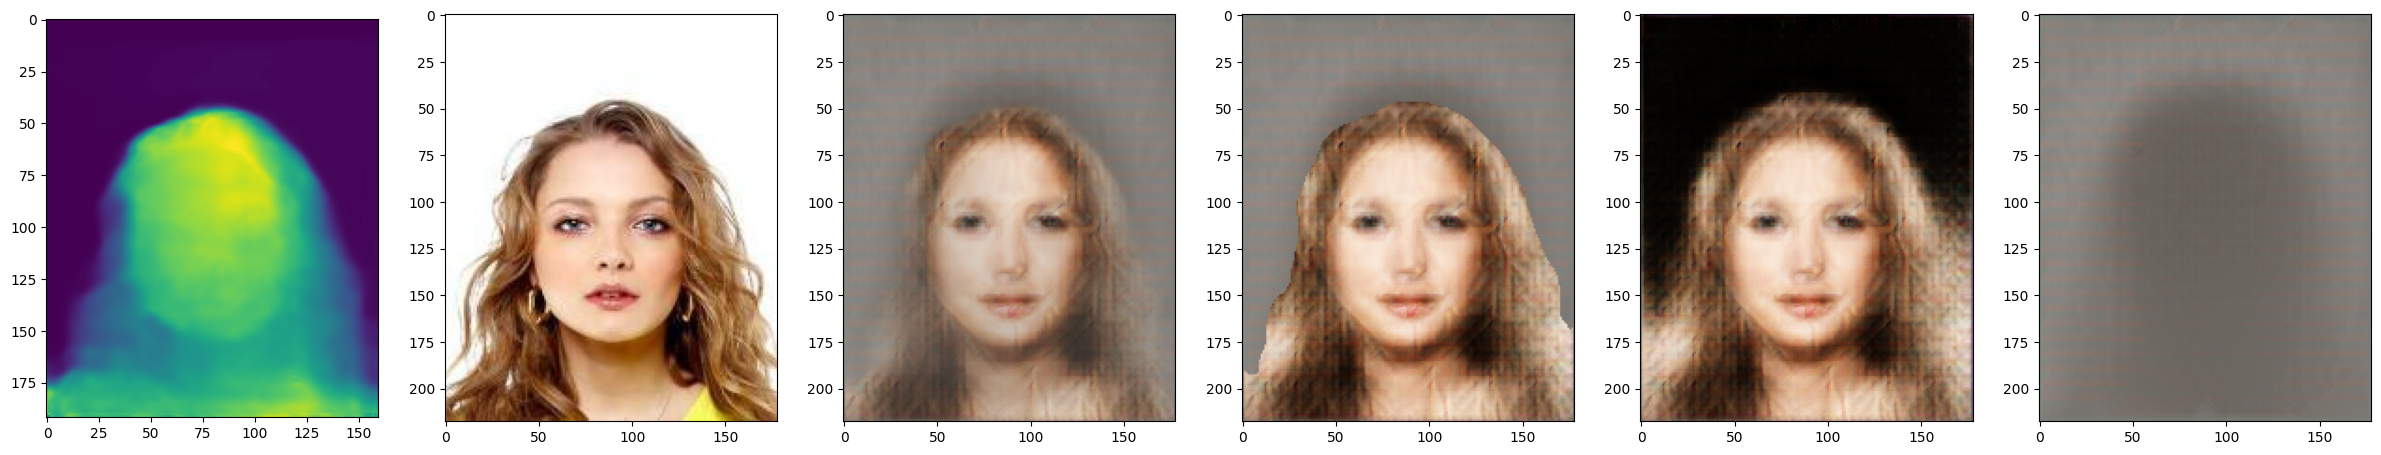

In [ ]:
i = 0
fg, fg_mask, bg, bg_mask = model(data_point(i), data_point_mask(i))
fg = fg.cpu().detach()[0]
fg_mask = fg_mask.cpu().detach()[0, 0]
bg = bg.cpu().detach()[0]
bg_mask = bg_mask.cpu().detach()[0, 0]
mask = data_point_mask(i)[0, 0].cpu().detach()


fig, ax = plt.subplots(1, 6)
fig.set_figwidth(30)
fig.set_figheight(15)

ax[0].imshow(torch.load(f'depths/0.pt')[i])
ax[1].imshow(to_pil_image(data[i]))
ax[2].imshow(to_pil_image(fg * mask + bg * (1 - mask)))
ax[3].imshow(to_pil_image(fg * fg_mask + bg * bg_mask))
ax[4].imshow(to_pil_image(fg))
ax[5].imshow(to_pil_image(bg))

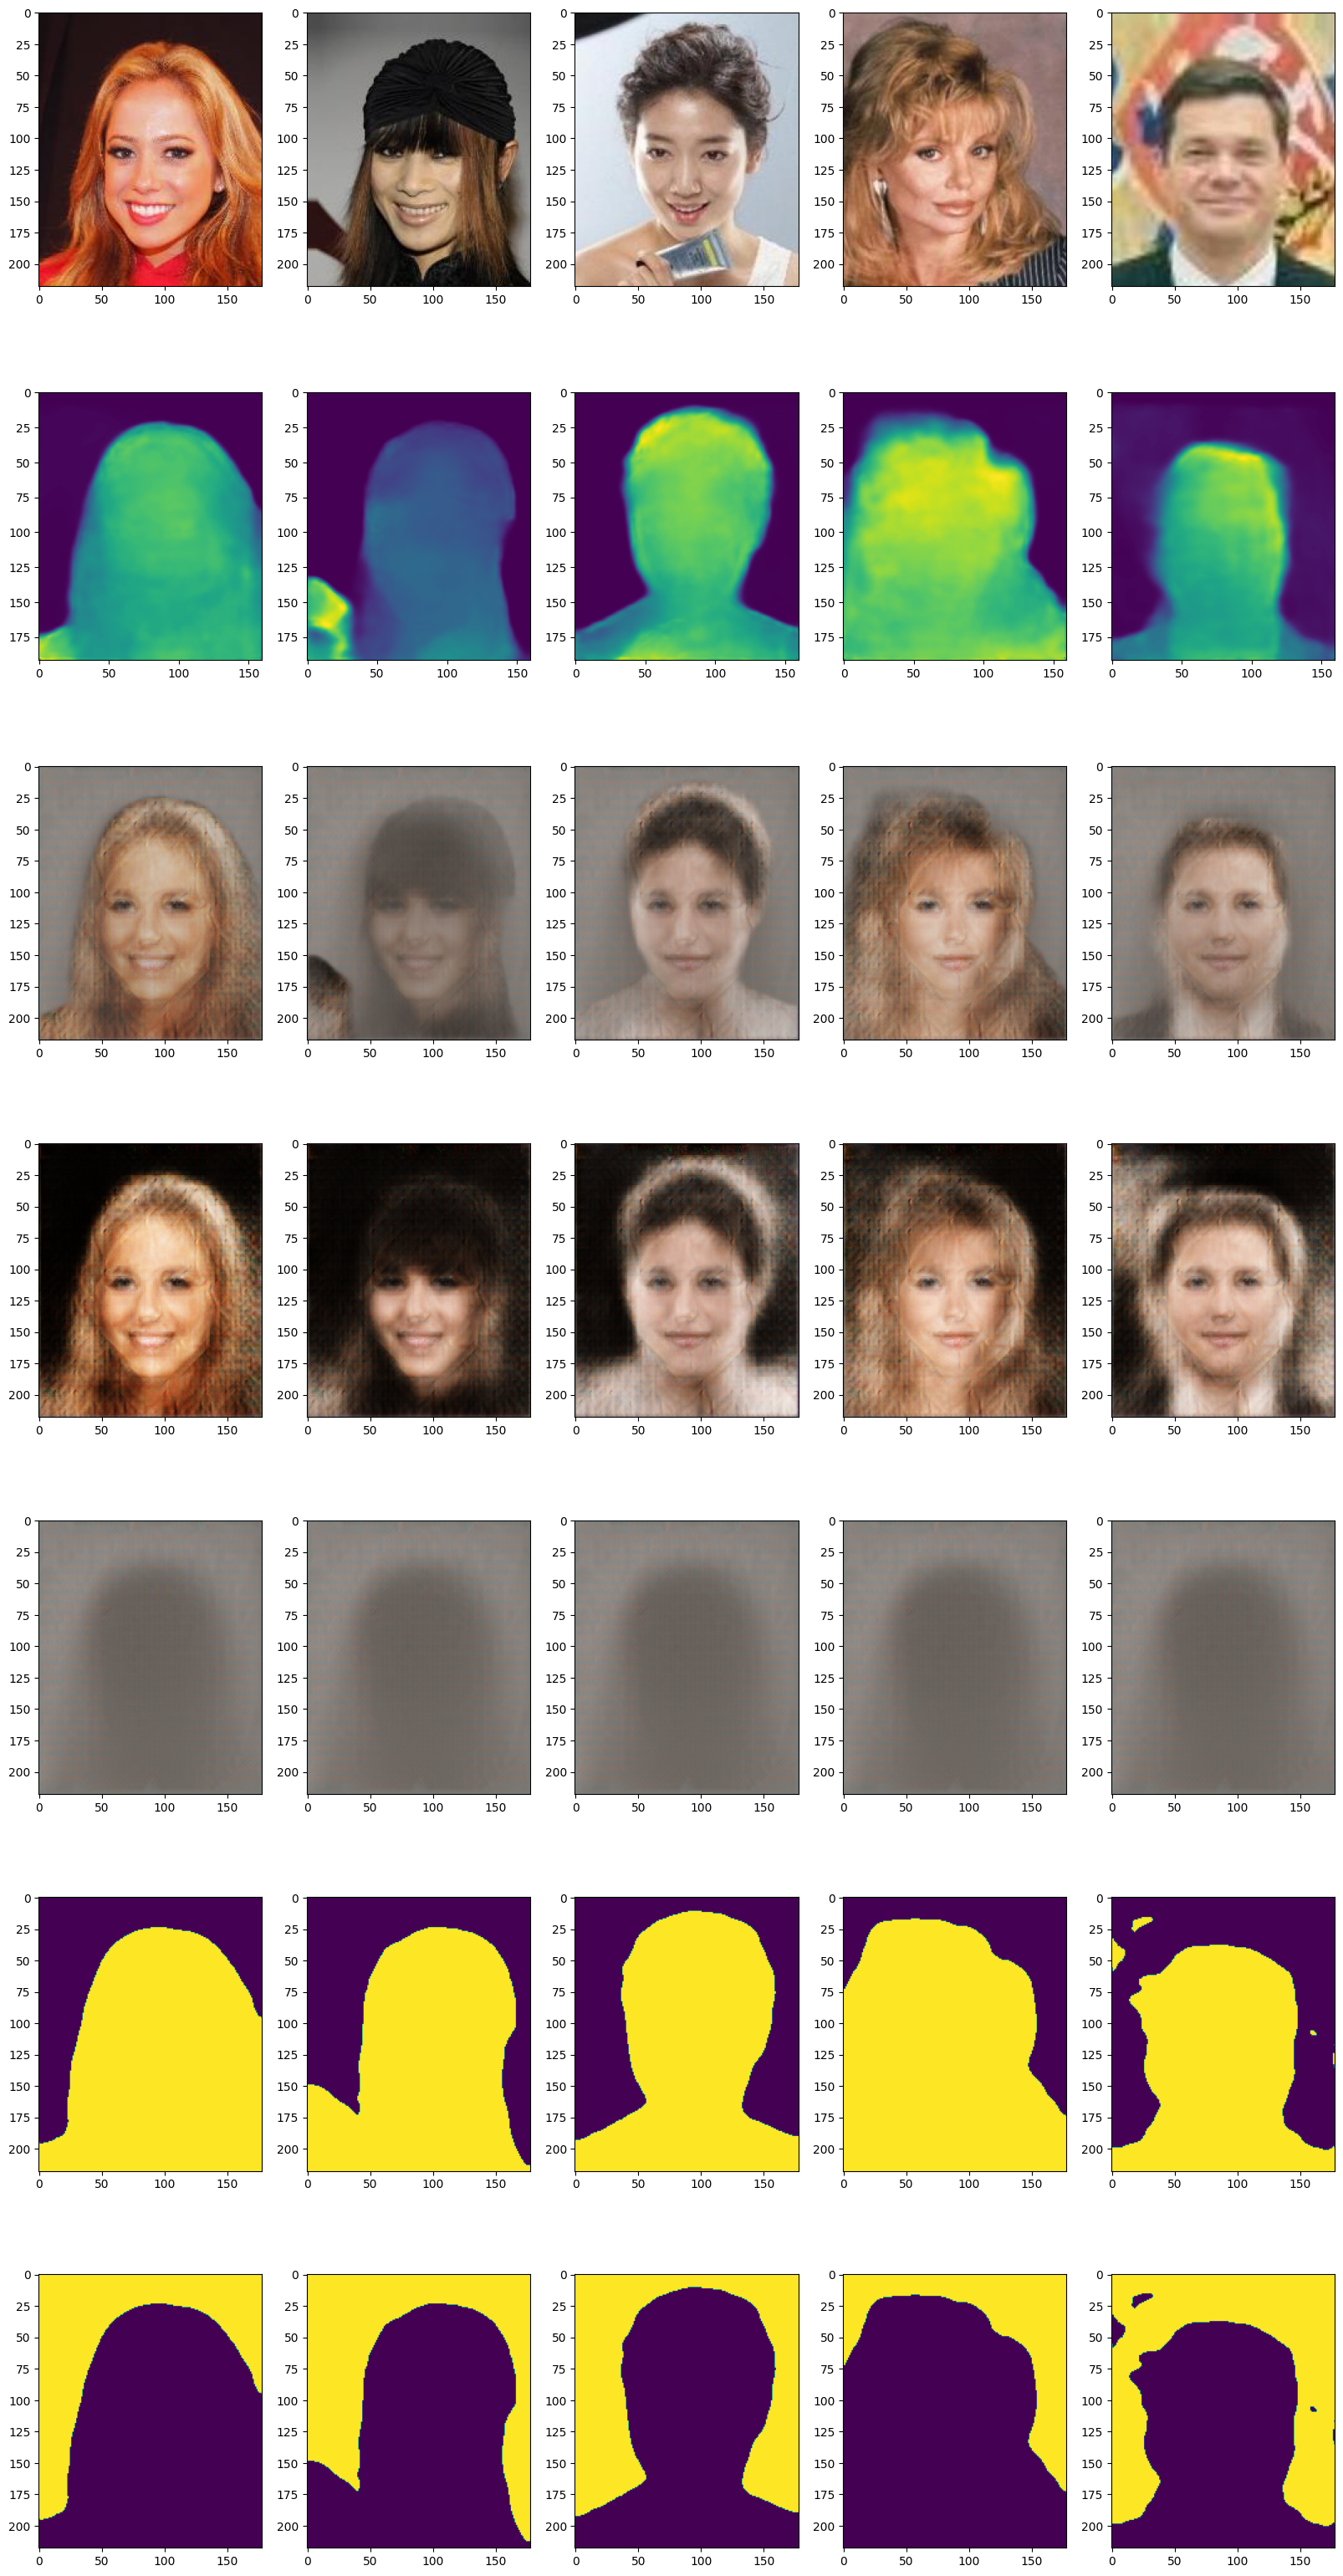

In [ ]:
examples = 5
offset = 5
fig, ax = plt.subplots(7, examples)
fig.set_figwidth(20)
fig.set_figheight(40)

for i in range(examples):
    ax[0, i].imshow(to_pil_image(data[i + offset]))

    ax[1, i].imshow(torch.load(f'depths/0.pt')[i + offset])

    fg, fg_mask, bg, bg_mask = model(data_point(i + offset), data_point_mask(i + offset))
    mask = data_point_mask(i + offset)[0, 0].cpu().detach()
    fg = fg.cpu().detach()[0]
    fg_mask = fg_mask.cpu().detach()[0, 0]
    bg = bg.cpu().detach()[0]
    bg_mask = bg_mask.cpu().detach()[0, 0]
    # img = fg * fg_mask + bg * bg_mask
    img = fg * mask + bg * (1 - mask)

    ax[2, i].imshow(to_pil_image(img))

    ax[3, i].imshow(to_pil_image(fg))

    ax[4, i].imshow(to_pil_image(bg))

    ax[5, i].imshow(fg_mask)

    ax[6, i].imshow(bg_mask)